## Download Package

In [1]:
! pip install scikit-learn==1.1.3

In [2]:
from tensorflow.keras import Model, Sequential, layers, optimizers, metrics, losses
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [3]:
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)
dtype = tf.float32

Get data.

In [4]:
# load data and labels
boston = load_boston()
data = boston.data
targets = boston.target

# divide into train and test splits
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2)

# Scale our inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

## Define Neural Network Model

Build and train neural network which we will use as basis function

In [5]:
# construct our model
model = Sequential()
model.add(layers.Dense(20, input_dim=13, activation='relu', name='layer_1'))
model.add(layers.Dense(8, activation='relu', name='layer_2'))
model.add(layers.Dense(1, activation='relu', name='layer_3'))

In [6]:
# compile the model
model.compile(optimizer=optimizers.Adam(),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.RootMeanSquaredError()],)

### Run Neural Network

In [7]:
# train the model for 200 epochs
num_epochs = 50
model.fit(X_train, y_train, epochs=num_epochs)
mse, rmse = model.evaluate(X_test, y_test)

Epoch 1/50
13/13 [==============================] - 1s 8ms/step - loss: 566.8325 - root_mean_squared_error: 23.8082
Epoch 2/50
13/13 [==============================] - 0s 3ms/step - loss: 549.1671 - root_mean_squared_error: 23.4343
Epoch 3/50
13/13 [==============================] - 0s 3ms/step - loss: 528.6706 - root_mean_squared_error: 22.9928
Epoch 4/50
13/13 [==============================] - 0s 3ms/step - loss: 505.4158 - root_mean_squared_error: 22.4815
Epoch 5/50
13/13 [==============================] - 0s 3ms/step - loss: 477.3111 - root_mean_squared_error: 21.8475
Epoch 6/50
13/13 [==============================] - 0s 3ms/step - loss: 446.2502 - root_mean_squared_error: 21.1246
Epoch 7/50
13/13 [==============================] - 0s 3ms/step - loss: 410.2539 - root_mean_squared_error: 20.2547
Epoch 8/50
13/13 [==============================] - 0s 3ms/step - loss: 368.9479 - root_mean_squared_error: 19.2080
Epoch 9/50
13/13 [==============================] - 0s 3ms/step - loss: 

In [8]:
# access the pen-ultimate laters
basis_func = Model(inputs=model.input,
                   outputs=model.get_layer('layer_2').output)

In [9]:
# obtain output of the second hidden layer by calling predict method
# layer_2_output = basis_func.predict(X_test)


In [10]:
# layer_2_output = basis_func.predict(X_test)

In [11]:
# layer_2_output.shape

## Define Bayesian Linear Regressor

This is a Python class for a Bayesian Last Layer neural network. This means that the last layer of the network is treated as a Bayesian linear regressor, with the preceding layers treated as a fixed feature extractor. This is a way of introducing uncertainty into the predictions of a neural network, which can be important in many applications (e.g. when the cost of mistakes is high, or when the data is very noisy).

Here's a step-by-step explanation of the code:

1. `__init__` method: This is the constructor of the class. It initializes the model, the basis layer, and some parameters for the Hamiltonian Monte Carlo (HMC) sampling.
    - `model`: The neural network model.
    - `basis_layer`: The name of the layer of `model` that will be used as the basis function.
    - `n_samples`: The number of HMC samples.
    - `n_burnin`: The number of burn-in steps for the HMC. Burn-in is a warm-up period during which the samples are discarded.
    - `step_size`: The step size for the HMC.
    - `n_leapfrog`: The number of leapfrog steps for the HMC.
    - `adaptive`: Whether to use adaptive HMC or not.

2. `initialize_basis_function` method: This method initializes the `basis_func` attribute as a new model that has the same input as `model`, but the output is the output of the layer specified by `basis_layer`.

3. `get_basis` method: This method returns the output of the `basis_func` for a given input `X`.

4. `fit` method: This method fits the Bayesian linear regressor on the data `X` and `y`.
    - First, it converts `X` and `y` to TensorFlow tensors and reshapes `y` to be a column vector.
    - It defines the joint distribution of the model parameters and the data. This is a hierarchical model where `y` is normally distributed with mean `X * beta + alpha` and standard deviation `sigma`, `beta` is a matrix of normally distributed coefficients, `alpha` is a normally distributed intercept, and `sigma` is a half-normal distributed standard deviation.
    - It defines the target log probability function as the log probability of the joint distribution.
    - It defines the HMC kernel for sampling from the target distribution.
    - If `adaptive` is `True`, it wraps the HMC kernel with an adaptive step size kernel.
    - It defines a `run_chain` function that runs the HMC and returns the samples and kernel results.
    - It runs the `run_chain` function and prints the acceptance rate of the HMC. If the acceptance rate is too low, the HMC parameters may need to be adjusted.
    - It extracts the post-burn-in samples of the model parameters from the `states` returned by `run_chain`.

5. `get_pred_dist` method: This method returns the predictive distribution of `y` for a given `X`.
    - It computes the mean of the predictive distribution as `X * beta + alpha`, where `beta` and `alpha` are the post-burn-in samples of the model parameters.
    - It adds normally distributed noise with standard deviation `sigma` to the mean to get the predictive distribution.

6. `predict` method: This method returns the mean and standard deviation of the predictive distribution of `y` for a given `X`.
    - It converts `X` to a TensorFlow tensor and gets the output of the `basis_func` for `X`.
    - It reshapes `X` to be a 3D tensor.
    - It computes the predictive distribution for each row of `X` using the `get_pred_dist` method.
    - It computes the mean and standard deviation of the predictive distribution across the samples of the model parameters.

### What's the idea behind Hamiltonian Monte Carlo (HMC) sampling?

Imagine you're playing a video game where you're a treasure hunter. You have a map that shows mountains, valleys, and flatlands. The goal is to collect as many treasures as possible, and these treasures are hidden in the valleys. However, the map is so large you can't possibly go to every valley to collect treasures.

What do you do? You could just wander around, but that might take forever. What if you could use a skateboard to glide through this landscape in a smarter way?

Hamiltonian Monte Carlo (HMC) is like that skateboard! In the world of data and statistics, the "valleys" are areas where the answers to our questions are most likely to be found. HMC helps us explore this complex landscape efficiently.

Here's how it works:

1. **Initial Point**: First, you start at a random place on the map.
  
2. **Speed and Direction**: Then you pick a random speed and direction (like pushing off on your skateboard).

3. **Glide**: You then "glide" through the map. If you're going uphill (which is not where the treasure is), the uphill slope will naturally slow you down. If you're going downhill (closer to the treasure), you'll pick up speed.

4. **Leapfrog Steps**: Along the way, you make little adjustments to your path (like shifting your weight on the skateboard) to make sure you're heading towards a valley. These adjustments are what they call "leapfrog steps."

5. **New Point**: Eventually, you'll stop and find a new point on the map. This point is like a "sample" that tells you something about where the treasures are most likely to be found.

6. **Repeat**: You do this over and over again, each time learning a bit more about where the treasures are hidden in the landscape.

The cool part is, because you're not just wandering around aimlessly, you find the treasures much faster and more efficiently. This is super useful in statistics and machine learning, where the "treasures" are the answers to questions we have about data.

So, in short, Hamiltonian Monte Carlo is a smart technique for exploring a complicated landscape to find the hidden "treasures" (or answers) as efficiently as possible!

### What's the difference between step size and leapfrog step?

In the context of Hamiltonian Monte Carlo (HMC), both "step size" and "leapfrog steps" are parameters that control how you explore the "landscape" of your problem, but they do so in slightly different ways.

### Step Size

Imagine you're on a skateboard, as in our earlier example. The "step size" is like how big each push of your foot is. A large step size means each push propels you a long way; a small step size means each push moves you only a little bit.

- **Large Step Size**: You'll move fast but might overshoot the valleys where the treasures are.
- **Small Step Size**: You'll move slowly and carefully, but it might take forever to get anywhere.

### Leapfrog Steps

The "leapfrog steps" are like the number of times you adjust your direction while you're gliding on your skateboard. After you give yourself the initial push (based on the step size), you glide and make small adjustments to your path to ensure you're heading in the right direction. Each of these adjustments is a "leapfrog step."

- **More Leapfrog Steps**: You make many small adjustments, which can help you navigate a complex landscape but might slow you down.
- **Fewer Leapfrog Steps**: You make fewer adjustments, which can be faster but riskier if the landscape is complicated.

### In Summary

- **Step Size**: Controls how far you move each time you "push off" in a new direction.
- **Leapfrog Steps**: Controls how many adjustments you make while you're "gliding" through the landscape.

Together, these parameters help you balance between exploring the landscape quickly and doing so accurately. You want to pick values that let you find the "treasures" (or answers) as efficiently as possible without missing them or taking too long.

### How does this `.fit()` method learn?

The `.fit()` method in this class is responsible for learning the Bayesian linear model for the last layer of the neural network. Here's how it works:

### Preparing the Data and Model

1. **Feature Extraction**: The method starts by taking the input data \( X \) and getting its representation from the neural network up to a specified layer (the "basis layer"). This representation is stored back in \( X \).
  
2. **Data Preparation**: Both \( X \) and \( y \) (the labels) are converted to TensorFlow tensors. The \( y \) tensor is reshaped to make sure it's a column vector.

3. **Joint Distribution Definition**: A joint probability distribution over \( \sigma \) (noise), \( \alpha \) (bias), \( \beta \) (model coefficients), and \( y \) (labels) is defined. This distribution reflects our beliefs about how these quantities relate to each other.

### Learning Through Sampling

4. **Log Probability Function**: A function (`target_log_prob_fn`) is defined to compute the log probability of a given state, which includes \( \alpha \), \( \beta \), and \( \sigma \). This function serves as the objective function that HMC tries to optimize.

5. **Setting up HMC**: The Hamiltonian Monte Carlo (HMC) kernel is set up to sample from the target distribution. If adaptive HMC is enabled, a wrapper around the basic HMC kernel is used to adapt the step size during the sampling.

6. **Running the Chain**: The HMC sampling is run using the TensorFlow function `tfp.mcmc.sample_chain`. It starts from an initial state of zeros for \( \alpha \) and \( \beta \) and ones for \( \sigma \). The method collects `self.n_samples` samples, discarding the first `self.n_burnin` as "burn-in" (samples that are typically discarded because the chain has not yet reached a stable state).

7. **Checking the Results**: After the sampling is done, it checks the "acceptance rate" to see how often the new samples were accepted during the HMC process. A low acceptance rate might indicate that the sampling is not efficient or that the HMC settings need to be adjusted.

8. **Storing the Samples**: Finally, it stores the samples of \( \alpha \), \( \beta \), and \( \sigma \) after the burn-in period. These samples represent the learned Bayesian model and can be used for making predictions with uncertainty.

### Summary

In essence, the `.fit()` method learns by:
- Transforming the input data \( X \) through the neural network up to a specific layer.
- Defining a Bayesian linear model for the last layer.
- Using HMC to sample from the posterior distribution of this Bayesian linear model.
  
After running `.fit()`, the object will have learned a Bayesian model for the last layer of the neural network, capturing not just point estimates but also uncertainties in its predictions.

### how does `tfp.mcmc.sample_chain()` work?

The function `tfp.mcmc.sample_chain` is a part of TensorFlow Probability (TFP), and it's used for running Markov Chain Monte Carlo (MCMC) simulations. In the specific context of the code you posted, it is being used to run Hamiltonian Monte Carlo (HMC), which is a type of MCMC method.

Here's a simplified explanation of what `tfp.mcmc.sample_chain` does:

### Basic Parameters:

- `num_results`: The number of samples you want to collect from the target distribution.
- `num_burnin_steps`: The number of initial steps to discard (known as "burn-in").
- `current_state`: The initial state of the Markov chain. It is the starting point for the MCMC simulation.
- `kernel`: The MCMC algorithm to use for sampling, such as HMC in this case.

### Steps:

1. **Initialization**: It starts with an initial state (`current_state`) and an MCMC kernel (`kernel`). The kernel contains all the rules on how to move from one state to another.

2. **Burn-in**: Before it starts collecting the samples you're interested in, it first runs for a certain number of "burn-in" steps. During this phase, the chain is allowed to wander around and reach a stable state that properly represents the target distribution.

3. **Sampling**: After the burn-in period, it starts collecting samples. For each step, it uses the kernel's rules to propose a new state based on the current state. Then, it decides whether to accept this new state or not. If accepted, the new state is added to the chain of samples.

4. **Result Collection**: It continues this process until it has collected the number of samples you specified in `num_results`.

5. **Return Values**: Finally, it returns two things:
    - `states`: The collected samples, which are supposed to be from the target distribution.
    - `kernel_results`: Additional diagnostic information like acceptance rates, which can be used to check if the MCMC simulation is performing well.

### In Summary:

`tfp.mcmc.sample_chain` is like a well-organized treasure hunt. You specify where to start (`current_state`), how long to practice before the real hunt begins (`num_burnin_steps`), and what rules to follow during the hunt (`kernel`). It then does the hunt for you and brings back the treasures (`states`) along with a logbook (`kernel_results`) that tells you how the hunt went.

By using `tfp.mcmc.sample_chain` in the `.fit()` method, the code is essentially running such a "treasure hunt" to learn the Bayesian model parameters \( (\alpha, \beta, \sigma) \).

### Analogy

Suppose you don't know that the value of $\pi$. You can create a MCMC simulation to recover an estimated number. The theory is that as long as you drop enough dots on the unit square and reject the dots outside of a quarter of circle, you'll get the correct value.

<p align="center">
    <img src="https://raw.githubusercontent.com/yiqiao-yin/Introduction-to-Machine-Learning-Big-Data-and-Application/main/pics/mc-sim-pi-adv.gif"></img>
</p>

Build Bayesian linear regressor

In [12]:
class BayesianLastLayer():

  def __init__(self,
                model,
                basis_layer,
                n_samples=2e4,
                n_burnin=5e3,
                step_size=1e-4,
                n_leapfrog=10,
                adaptive=False):
      # Setting up our model
      self.model = model
      self.basis_layer = basis_layer
      self.initialize_basis_function()
      # HMC Settings
      # number of hmc samples
      self.n_samples = int(n_samples)
      # number of burn-in steps
      self.n_burnin = int(n_burnin)
      # HMC step size
      self.step_size = step_size
      # HMC leapfrog steps
      self.n_leapfrog = n_leapfrog
      # whether to be adaptive or not
      self.adaptive = adaptive

  # define helper function for using the neural network as a basis function
  def initialize_basis_function(self):
      self.basis_func = Model(inputs=self.model.input,
                              outputs=self.model.get_layer(self.basis_layer).output)

  # define helper function to easily get predictions from helper function
  def get_basis(self, X):
      return self.basis_func.predict(X)

  # define fuction for fitting the Bayesian linear regressor on data
  def fit(self, X, y):
      X = tf.convert_to_tensor(self.get_basis(X), dtype=dtype)
      y = tf.convert_to_tensor(y, dtype=dtype)
      y = tf.reshape(y, (-1, 1))
      D = X.shape[1]

      # Define our joint distribution
      distribution = tfp.distributions.JointDistributionNamedAutoBatched(
          dict(
              sigma=tfp.distributions.HalfNormal(scale=tf.ones([1])),
              alpha=tfp.distributions.Normal(
                  loc=tf.zeros([1]),
                  scale=tf.ones([1]),
              ),
              beta=tfp.distributions.Normal(
                  loc=tf.zeros([D,1]),
                  scale=tf.ones([D,1]),
              ),
              y=lambda beta, alpha, sigma:
                  tfp.distributions.Normal(
                      loc=tf.linalg.matmul(X, beta) + alpha,
                      scale=sigma
                  )
              )
          )

      # Define the log probability function
      def target_log_prob_fn(beta, alpha, sigma):
          return distribution.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

      # Define the HMC kernel we'll be using for sampling
      hmc_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=self.step_size,
        num_leapfrog_steps=self.n_leapfrog
      )

      # We can use adaptive HMC to automatically adjust the kernel step size
      if self.adaptive:
          adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel = hmc_kernel,
            num_adaptation_steps=int(self.n_burnin * 0.8)
          )

      # If we define a function, we can extend this to multiple chains.
      @tf.function
      def run_chain():
          states, kernel_results = tfp.mcmc.sample_chain(
                num_results=self.n_samples,
                num_burnin_steps=self.n_burnin,
                current_state=[
                    tf.zeros((X.shape[1],1), name='init_model_coeffs'),
                    tf.zeros((1), name='init_bias'),
                    tf.ones((1), name='init_noise'),
                ],
                kernel=hmc_kernel
              )
          return states, kernel_results

      print(f'Running HMC with {self.n_samples} samples.')
      states, kernel_results = run_chain()

      print('Completed HMC sampling.')
      coeffs, bias, noise_std = states
      accepted_samples = kernel_results.is_accepted[self.n_burnin:]
      acceptance_rate = 100*np.mean(accepted_samples)
      # Print the acceptance rate - if this is low, we need to check our
      # HMC parameters
      print('Acceptance rate: %0.1f%%' % (acceptance_rate))

      # Obtain the post-burnin samples
      self.model_coeffs = coeffs[self.n_burnin:,:,0]
      self.bias = bias[self.n_burnin:]
      self.noise_std = noise_std[self.n_burnin:]

  def get_pred_dist(self, X):
      predictions = (tf.matmul(X, tf.transpose(self.model_coeffs)) +
                    self.bias[:,0])
      noise = (self.noise_std[:,0] *
              tf.random.normal([self.noise_std.shape[0]]))
      return predictions + noise

  def predict(self, X):
      X = tf.convert_to_tensor(self.get_basis(X), dtype=dtype)
      pred_dist = np.zeros((X.shape[0], self.model_coeffs.shape[0]))
      X = tf.reshape(X, (-1, 1, X.shape[1]))
      for i in range(X.shape[0]):
        pred_dist[i,:] = self.get_pred_dist(X[i,:])

      y_pred = np.mean(pred_dist, axis=1)
      y_std = np.std(pred_dist, axis=1)
      return y_pred, y_std

### Run Bayesian Network

In [13]:
# instatiate last layer model
bll = BayesianLastLayer(model, 'layer_2')
# fit model on training data
bll.fit(X_train, y_train)
# perform inference
y_pred, y_std = bll.predict(X_test)

13/13 [==============================] - 0s 4ms/step
Running HMC with 20000 samples.


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Completed HMC sampling.
Acceptance rate: 100.0%
4/4 [==============================] - 0s 4ms/step


## Compare Results

Recall the original neural network model performance.

In [14]:
_, rmse = model.evaluate(X_test, y_test)
print('RMSE: %.3f' % rmse)

4/4 [==============================] - 0s 4ms/step - loss: 15.4245 - root_mean_squared_error: 3.9274
RMSE: 3.927


Perform on the same test data.

In [15]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(y_test, y_pred)
new_rmse = m.result().numpy()
print('New RMSE: %.3f' % new_rmse)

New RMSE: 3.950


In [16]:
y_pred_1 = model.predict(X_test)
y_pred_2 = y_pred

4/4 [==============================] - 0s 3ms/step


In [18]:
import matplotlib.pyplot as plt

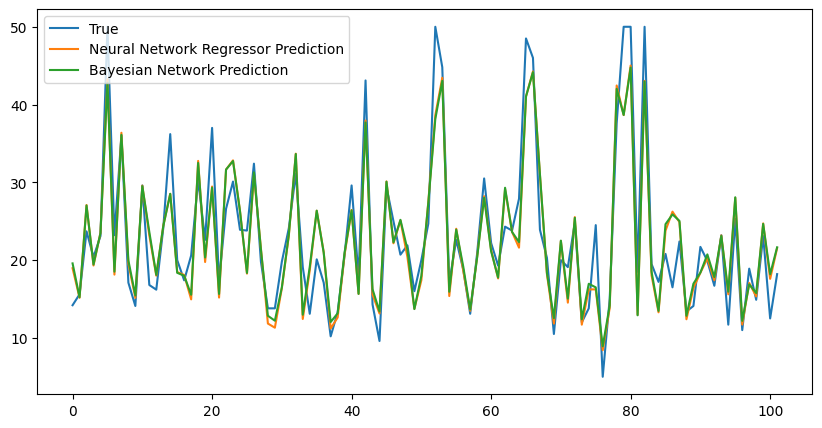

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True')
plt.plot(y_pred_1, label='Neural Network Regressor Prediction')
plt.plot(y_pred_2, label='Bayesian Network Prediction')
plt.legend()
plt.show()

In [22]:
import numpy as np

In [26]:
y_pred_1 = y_pred_1.reshape(-1)
y_pred_2 = y_pred_2.reshape(-1)

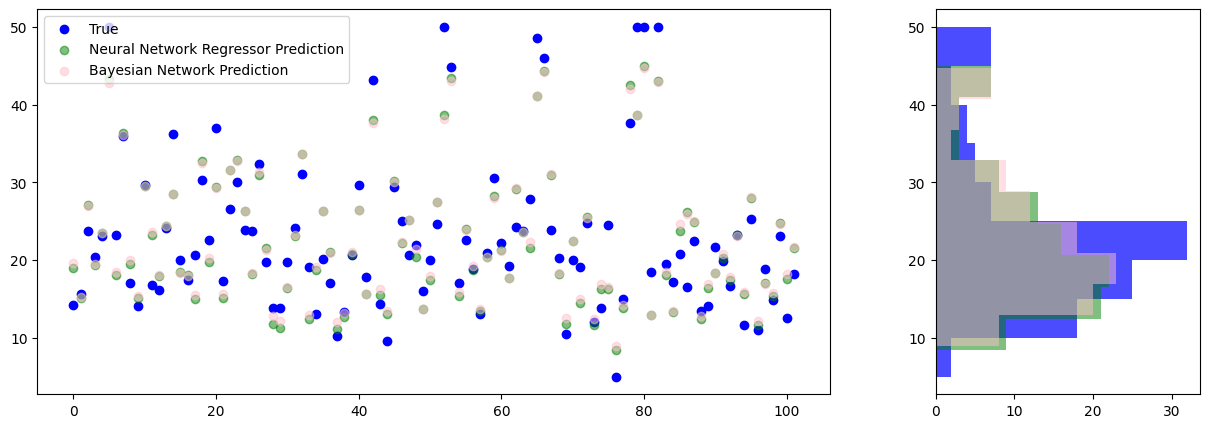

In [28]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 1]})

# Scatter plots
# Scatter plot for y_test with blue color
axes[0].scatter(range(len(y_test)), y_test, color='blue', label='True')

# Scatter plot for y_pred_1 with green color and transparency of 0.5
axes[0].scatter(range(len(y_pred_1)), y_pred_1, color='green', alpha=0.5, label='Neural Network Regressor Prediction')

# Scatter plot for y_pred_2 with pink color and transparency of 0.5
axes[0].scatter(range(len(y_pred_2)), y_pred_2, color='pink', alpha=0.5, label='Bayesian Network Prediction')

# Add legend to the scatter plot
axes[0].legend()

# Histograms
# Histogram for y_test
axes[1].hist(y_test, color='blue', alpha=0.7, label='True', orientation='horizontal', bins=np.linspace(min(y_test), max(y_test), 10))

# Histogram for y_pred_1
axes[1].hist(y_pred_1, color='green', alpha=0.5, label='Neural Network Regressor Prediction', orientation='horizontal', bins=np.linspace(min(y_pred_1), max(y_pred_1), 10))

# Histogram for y_pred_2
axes[1].hist(y_pred_2, color='pink', alpha=0.5, label='Bayesian Network Prediction', orientation='horizontal', bins=np.linspace(min(y_pred_2), max(y_pred_2), 10))

# Add legend to the histogram plot
# axes[1].legend()

# Show the plots
plt.show()
